![](https://github.com/rajeevratan84/ModernComputerVision/raw/main/logo_MCV_W.png)

# **PyTorch Model Performance Analysis**
---



---



In this lesson, we learn use the MNIST model we trained in the previously lesson and analyze it's performance, we do:
1. Setup Our PyTorch Model and Data
2. Load the previously trained model
3. View the images we misclassified
4. Create a Confusion Matrix
5. Create Classification Report


# **1. Setup our PyTorch Imports, Model and Load the MNIST Dataset**

We only need to load the Test dataset since we're analyzing performance on that data segment.

In [1]:
!wget https://moderncomputervision.s3.eu-west-2.amazonaws.com/mnist_cnn_net.pth

--2023-06-07 13:30:26--  https://moderncomputervision.s3.eu-west-2.amazonaws.com/mnist_cnn_net.pth
Resolving moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)... 52.95.148.198
Connecting to moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)|52.95.148.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4802439 (4.6M) [binary/octet-stream]
Saving to: ‘mnist_cnn_net.pth’

mnist_cnn_net.pth   100%[===================>]   4.58M  5.53MB/s    in 0.8s    

2023-06-07 13:30:28 (5.53 MB/s) - ‘mnist_cnn_net.pth’ saved [4802439/4802439]



In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools


print("GPU available: {}".format(torch.cuda.is_available()))

device = 'cuda'

GPU available: True


#### **Our Image plotting function**

In [3]:
def imgshow(title, image = None, size = 6):
  h, w = image.shape[:2]
  aspect_ratio = w/h
  plt.figure(figsize=(size * aspect_ratio,size))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.title(title)
  plt.show()

### **Loading our MNIST Test Dataset**

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])

# Load our Test Data and specify what transform to use when loading
testset = torchvision.datasets.MNIST('mnist', train = False, download = True, transform = transform)

testloader = torch.utils.data.DataLoader(testset, batch_size = 128, shuffle = False, num_workers = 0)

100%|██████████| 9912422/9912422 [00:00<00:00, 43569723.20it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 91148001.37it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 12693086.04it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 18806050.12it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



### **Creating our Model Defination Class**

In [5]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(64 * 12 * 12, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = x.reshape(x.shape[0], -1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

# **2. Loading Out Model**

I have uploaded the model to my Google Drive - https://drive.google.com/file/d/1yj01iUbYL8ZXHiYRE5Xd639tddSAkzKs/view?usp=sharing

We use gdown in our terminal to download the model file that we trained in the last lesson.

March 4th 2022 Update: File moved to S3

#### **NOTE**

When Loading our model we need to create the model instance i.e. ```net = Net()``` and then since we trained it using our GPU in Colab, we move it to the GPU using ```net.to(device``` where device = 'cuda'.

Then we can load our downloaded model's weights. 

In [6]:
net = Net()
net.to(device)

net.load_state_dict(torch.load('mnist_cnn_net.pth'))

<All keys matched successfully>

Model Loaded successfully if ```All keys matched successfully``` is displayed.

### **Now Let's calculate it's accuracy (done in the prevoiusly lesson so this is just a recap) on the Test Data**



In [7]:
correct = 0 
total = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data
    # Move our data to GPU
    images = images.to(device)
    labels = labels.to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10000 test images: {accuracy:.3}%')

Accuracy of the network on the 10000 test images: 98.7%


# **3. Displaying our Misclassified Images** ##

Out of 10,000 images our model predicted 98.7% correct. This is good for a first attempt with such a simple model. (there are much better models).

**A Good Practise!** 

It's a good habit when creating image classifiers to visually inspect the images being mis-classified.
1. We can spot what types of images are challenging for our model
2. We can spot any incorrectly labeled images
3. If sometimes we can't correctly identify the class, seeing your CNN struggle hurts less :)

**Reminder** on why we use ```net.eval()``` and ```torch.no_grad()```

[Taken from Stackoverflow:](https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch)

**model.eval()** is a kind of switch for some specific layers/parts of the model that behave differently during training and inference (evaluating) time. For example, **Dropouts** Layers, BatchNorm Layers etc. You need to turn off them during model evaluation, and .eval() will do it for you. In addition, the common practice for evaluating/validation is using torch.no_grad() in pair with model.eval() to turn off gradients computation.

So, while we don't use Dropouts or BatchNorm in our model, it's good practice to use it when doing inference.

Actual Label: 3, Predicted Label: 8


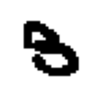

Actual Label: 4, Predicted Label: 9


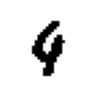

Actual Label: 4, Predicted Label: 2


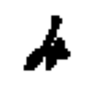

Actual Label: 6, Predicted Label: 0


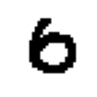

Actual Label: 2, Predicted Label: 7


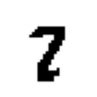

Actual Label: 5, Predicted Label: 3


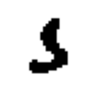

Actual Label: 6, Predicted Label: 0


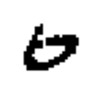

Actual Label: 3, Predicted Label: 5


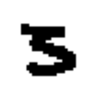

Actual Label: 8, Predicted Label: 2


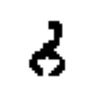

Actual Label: 2, Predicted Label: 7


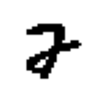

Actual Label: 1, Predicted Label: 8


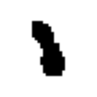

Actual Label: 2, Predicted Label: 1


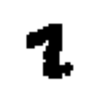

Actual Label: 7, Predicted Label: 3


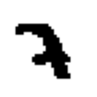

Actual Label: 4, Predicted Label: 9


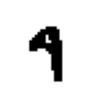

Actual Label: 9, Predicted Label: 8


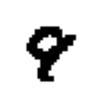

Actual Label: 9, Predicted Label: 7


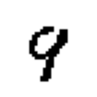

Actual Label: 3, Predicted Label: 5


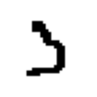

Actual Label: 3, Predicted Label: 5


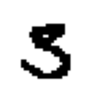

Actual Label: 8, Predicted Label: 9


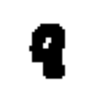

Actual Label: 6, Predicted Label: 0


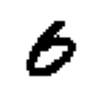

Actual Label: 6, Predicted Label: 5


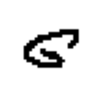

Actual Label: 7, Predicted Label: 2


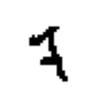

Actual Label: 6, Predicted Label: 5


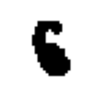

Actual Label: 7, Predicted Label: 2


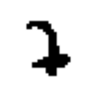

Actual Label: 9, Predicted Label: 4


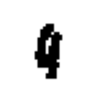

Actual Label: 4, Predicted Label: 9


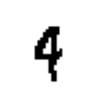

Actual Label: 9, Predicted Label: 5


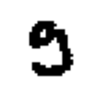

Actual Label: 8, Predicted Label: 0


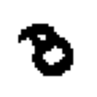

Actual Label: 7, Predicted Label: 2


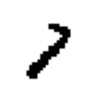

Actual Label: 8, Predicted Label: 2


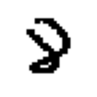

Actual Label: 7, Predicted Label: 9


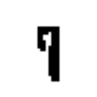

Actual Label: 1, Predicted Label: 6


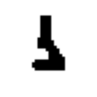

Actual Label: 8, Predicted Label: 7


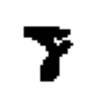

Actual Label: 9, Predicted Label: 3


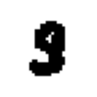

Actual Label: 0, Predicted Label: 6


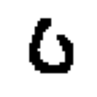

Actual Label: 2, Predicted Label: 0


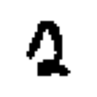

Actual Label: 9, Predicted Label: 5


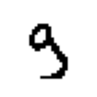

Actual Label: 8, Predicted Label: 0


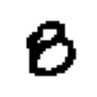

Actual Label: 2, Predicted Label: 8


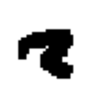

Actual Label: 9, Predicted Label: 4


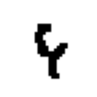

Actual Label: 1, Predicted Label: 7


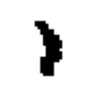

Actual Label: 5, Predicted Label: 3


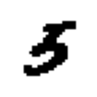

Actual Label: 2, Predicted Label: 0


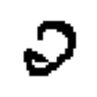

Actual Label: 6, Predicted Label: 0


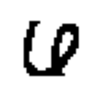

Actual Label: 9, Predicted Label: 8


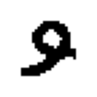

Actual Label: 4, Predicted Label: 9


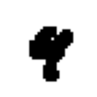

Actual Label: 6, Predicted Label: 1


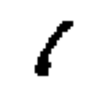

Actual Label: 9, Predicted Label: 0


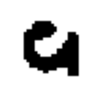

Actual Label: 9, Predicted Label: 1


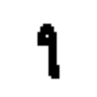

Actual Label: 9, Predicted Label: 4


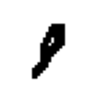

Actual Label: 9, Predicted Label: 4


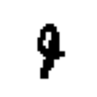

Actual Label: 6, Predicted Label: 8


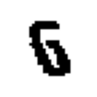

Actual Label: 2, Predicted Label: 4


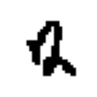

Actual Label: 5, Predicted Label: 3


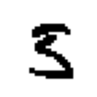

Actual Label: 7, Predicted Label: 8


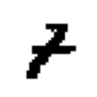

Actual Label: 6, Predicted Label: 1


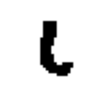

Actual Label: 9, Predicted Label: 4


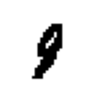

Actual Label: 8, Predicted Label: 0


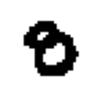

Actual Label: 3, Predicted Label: 8


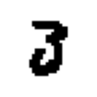

Actual Label: 9, Predicted Label: 5


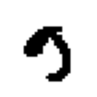

Actual Label: 3, Predicted Label: 5


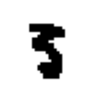

Actual Label: 6, Predicted Label: 8


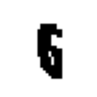

Actual Label: 9, Predicted Label: 7


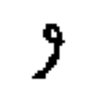

Actual Label: 1, Predicted Label: 2


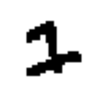

Actual Label: 6, Predicted Label: 0


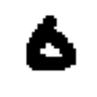

Actual Label: 9, Predicted Label: 1


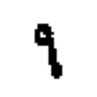

Actual Label: 6, Predicted Label: 4


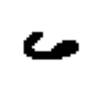

Actual Label: 6, Predicted Label: 5


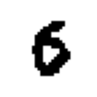

Actual Label: 5, Predicted Label: 0


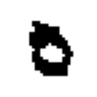

Actual Label: 8, Predicted Label: 5


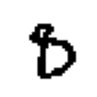

Actual Label: 4, Predicted Label: 9


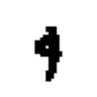

Actual Label: 8, Predicted Label: 9


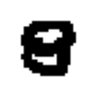

Actual Label: 7, Predicted Label: 2


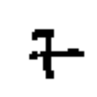

Actual Label: 7, Predicted Label: 2


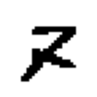

Actual Label: 7, Predicted Label: 8


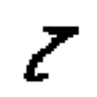

Actual Label: 1, Predicted Label: 3


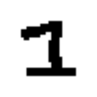

Actual Label: 4, Predicted Label: 2


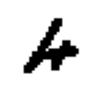

Actual Label: 7, Predicted Label: 1


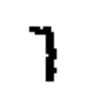

Actual Label: 6, Predicted Label: 5


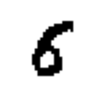

Actual Label: 0, Predicted Label: 2


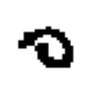

Actual Label: 8, Predicted Label: 0


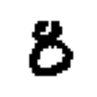

Actual Label: 9, Predicted Label: 3


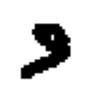

Actual Label: 9, Predicted Label: 0


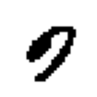

Actual Label: 2, Predicted Label: 7


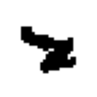

Actual Label: 9, Predicted Label: 7


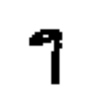

Actual Label: 2, Predicted Label: 8


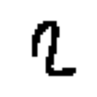

Actual Label: 8, Predicted Label: 7


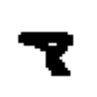

Actual Label: 6, Predicted Label: 5


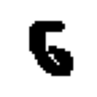

Actual Label: 6, Predicted Label: 8


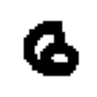

Actual Label: 7, Predicted Label: 9


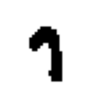

Actual Label: 8, Predicted Label: 9


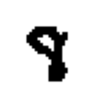

Actual Label: 3, Predicted Label: 5


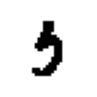

Actual Label: 9, Predicted Label: 8


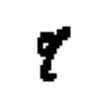

Actual Label: 4, Predicted Label: 9


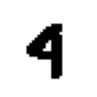

Actual Label: 8, Predicted Label: 0


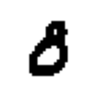

Actual Label: 6, Predicted Label: 0


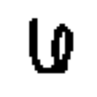

Actual Label: 4, Predicted Label: 9


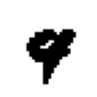

Actual Label: 0, Predicted Label: 8


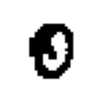

Actual Label: 1, Predicted Label: 6


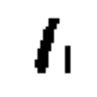

Actual Label: 2, Predicted Label: 8


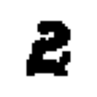

Actual Label: 3, Predicted Label: 8


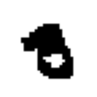

Actual Label: 3, Predicted Label: 8


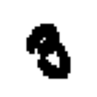

Actual Label: 5, Predicted Label: 9


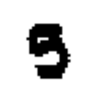

Actual Label: 5, Predicted Label: 9


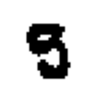

Actual Label: 9, Predicted Label: 3


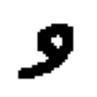

Actual Label: 0, Predicted Label: 5


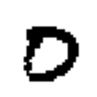

Actual Label: 9, Predicted Label: 7


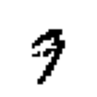

Actual Label: 7, Predicted Label: 1


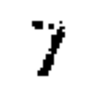

Actual Label: 0, Predicted Label: 7


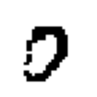

Actual Label: 8, Predicted Label: 2


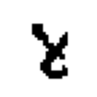

Actual Label: 0, Predicted Label: 2


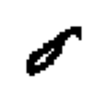

Actual Label: 2, Predicted Label: 1


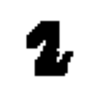

Actual Label: 2, Predicted Label: 8


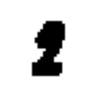

Actual Label: 6, Predicted Label: 4


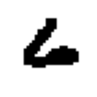

Actual Label: 8, Predicted Label: 6


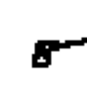

Actual Label: 4, Predicted Label: 9


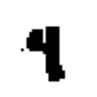

Actual Label: 4, Predicted Label: 9


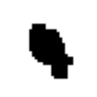

Actual Label: 7, Predicted Label: 2


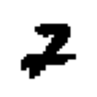

Actual Label: 7, Predicted Label: 2


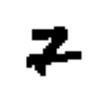

Actual Label: 1, Predicted Label: 8


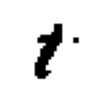

Actual Label: 0, Predicted Label: 8


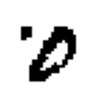

Actual Label: 9, Predicted Label: 7


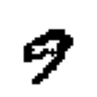

Actual Label: 2, Predicted Label: 7


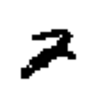

Actual Label: 6, Predicted Label: 2


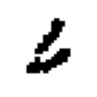

Actual Label: 5, Predicted Label: 6


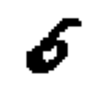

Actual Label: 5, Predicted Label: 0


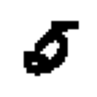

Actual Label: 2, Predicted Label: 3


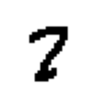

In [8]:
net.eval()

with torch.no_grad():
  for data in testloader:
    images, labels = data

    # Move our data to GPU
    images = images.to(device)
    labels = labels.to(device)

    # Get our outputs
    outputs = net(images)

    # use torch.argmax() to get the predictions, argmax is used for long_tensors
    predictions = torch.argmax(outputs, dim=1)

    # For test data in each batch we identify when predictions did not match the labe
    # then we print out the actual ground truth 
    for i in range(data[0].shape[0]):
      pred = predictions[i].item()
      label = labels[i]
      if(label != pred):
        print(f'Actual Label: {label}, Predicted Label: {pred}')       
        img = np.reshape(images[i].cpu().numpy(),[28,28])
        imgshow("", np.uint8(img), size=1)

# **4. Creating our Confusion Matrix**

We use Sklean's Confusion Matrix tool to create it. All we need is:
1. The true labels
2. The predicted labels


In [9]:
pred_list = torch.zeros(0, dtype=torch.long, device='cpu')
label_list = torch.zeros(0, dtype=torch.long, device='cpu')

with torch.no_grad():
  for i, (inputs, classes) in enumerate(testloader):
    inputs = inputs.to(device)
    classes = classes.to(device)
    outputs = net(inputs)
    _, preds = torch.max(outputs, 1)

    # Append batch prediction results
    pred_list = torch.cat([pred_list, preds.view(-1).cpu()])
    label_list = torch.cat([label_list, classes.view(-1).cpu()])

# Confusion matrix
conf_mat = confusion_matrix(label_list.numpy(), pred_list.numpy())
print(conf_mat)

[[ 973    0    2    0    0    1    1    1    2    0]
 [   0 1128    1    1    0    0    2    1    2    0]
 [   2    2 1018    1    1    0    0    4    4    0]
 [   0    0    0 1001    0    5    0    0    4    0]
 [   0    0    2    0  971    0    0    0    0    9]
 [   2    0    0    3    0  884    1    0    0    2]
 [   6    2    1    0    2    5  939    0    3    0]
 [   0    2    7    1    0    0    0 1014    2    2]
 [   5    0    3    0    0    1    1    2  959    3]
 [   2    2    0    3    5    3    0    5    3  986]]


#### **Interpreting the Confusion Matrix**
![](https://github.com/rajeevratan84/ModernComputerVision/raw/main/CleanShot%202020-11-30%20at%2010.46.45.png)

### **Creating a more presentable plot**

We'll reuse this nicely done function from the sklearn documentation on plotting a confusion matrix using color gradients and labels.

In [10]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
  accuracy = np.trace(cm) / np.sum(cm).astype('float')
  misclass = 1 - accuracy

  if cmap is None:
    cmap = plt.get_cmap('Blues')
    
  plt.figure(figsize=(8, 6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


  thresh = cm.max() / 1.5 if normalize else cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if normalize:
      plt.text(j, i, "{:0.4f}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    else:
      plt.text(j, i, "{:,}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")


  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
  plt.show()

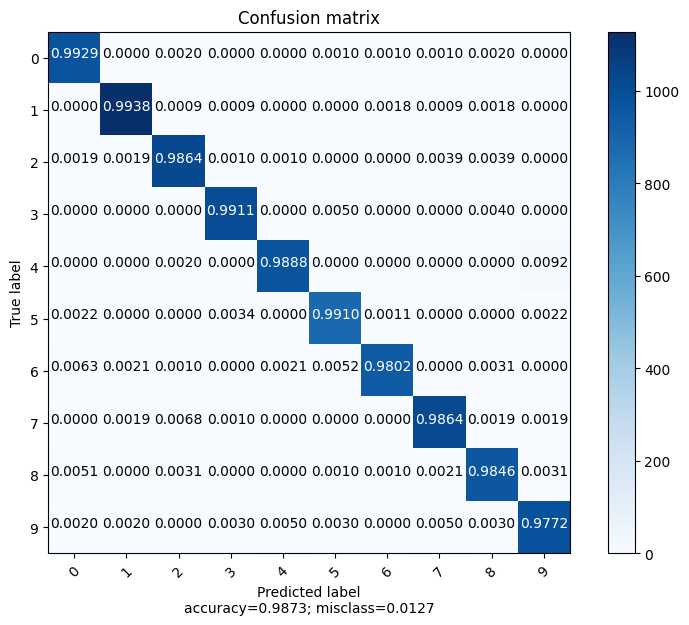

In [11]:
target_names = list(range(0,10))
plot_confusion_matrix(conf_mat, target_names)

## **Let's look at our per-class accuracy**

In [12]:
class_accuracy = 100 * conf_mat.diagonal() / conf_mat.sum(1)

for (i,ca) in enumerate(class_accuracy):
  print(f'Accuracy for {i} : {ca:.3f}%')

Accuracy for 0 : 99.286%
Accuracy for 1 : 99.383%
Accuracy for 2 : 98.643%
Accuracy for 3 : 99.109%
Accuracy for 4 : 98.880%
Accuracy for 5 : 99.103%
Accuracy for 6 : 98.017%
Accuracy for 7 : 98.638%
Accuracy for 8 : 98.460%
Accuracy for 9 : 97.721%


# **5. Now let's look at the Classification Report**

In [13]:
print(classification_report(label_list.numpy(), pred_list.numpy()))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



### **5.1 Support is the total sum of that class in the dataset**

### **5.2 Review of Recall**

![](https://github.com/rajeevratan84/ModernComputerVision/raw/main/CleanShot%202020-11-30%20at%2011.11.12.png)

### **5.3 Review of Precision**

![](https://github.com/rajeevratan84/ModernComputerVision/raw/main/CleanShot%202020-11-30%20at%2011.11.22.png)

### **5.4 High recall (or sensitivity) with low precision.**
This tells us that most of the positive examples are correctly recognized (low False Negatives) but there are a lot of false positives i.e. other classes being predicted as our class in question. 

### **5.5 Low recall (or sensitivity) with high precision.**

Our classifier is missing a lot of positive examples (high FN) but those we predaict as positive are indeed positive (low False Positives)
